In [1]:
import io, requests, glob, os, math
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


c:\Python3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [3]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

with sqlite3.connect("covid.db") as conn:
    data.to_sql(name='DataRaw', con=conn, if_exists='replace', index=False)
    data = pd.read_sql("""
WITH Analyzed AS (
SELECT
    date(Datum, '-1 day') AS Datum,
    BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung,
    BestaetigteFaelleBundeslaender - LAG(BestaetigteFaelleBundeslaender, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS Neuinfektionen,
    CASE WHEN TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) > 1000000 THEN NULL ELSE TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) END AS TestungenPCR,
    Hospitalisierung - LAG(Hospitalisierung, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS HospitalisierungDiff
FROM DataRaw)
SELECT 
    Datum, BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung, HospitalisierungDiff,
    CASE WHEN Neuinfektionen >= 0 THEN Neuinfektionen ELSE NULL END AS Neuinfektionen,
    CASE WHEN TestungenPCR >= 0 THEN TestungenPCR ELSE NULL END AS TestungenPCR,    
    AVG(Neuinfektionen) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Neuinfektionen7DayAvg,
    AVG(Hospitalisierung) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Hospitalisierung7DayAvg,
    AVG(TestungenPCR) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS TestungenPCR7DayAvg
FROM Analyzed;
    """, conn)
    for bl in data["Name"].unique():
        for param in ["TestungenPCR", "HospitalisierungDiff", "Hospitalisierung", "Neuinfektionen"]:
            data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")
        # Fill na values for first diff.
        data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.to_sql(name='DataAnalyzed', con=conn, if_exists='replace', index=False)
    conn.execute("VACUUM")


In [4]:
with sqlite3.connect("covid.db") as conn:
    data = pd.read_sql("SELECT * FROM DataAnalyzed ORDER BY Datum, BundeslandId", conn)
    data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)

## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [5]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-05-04,247,313,1 357,800,275,487,337,186,1 753,5 755
2022-05-05,167,290,1 680,830,258,675,297,182,1 622,6 001
2022-05-06,193,251,1 233,729,276,553,269,103,1 561,5 168
2022-05-07,239,225,1 051,589,169,323,220,109,692,3 617
2022-05-08,129,178,1 127,485,157,267,188,126,1 476,4 133
2022-05-09,124,163,639,516,410,422,412,216,1 120,4 022
2022-05-10,283,191,1 521,854,280,693,371,169,1 629,5 991


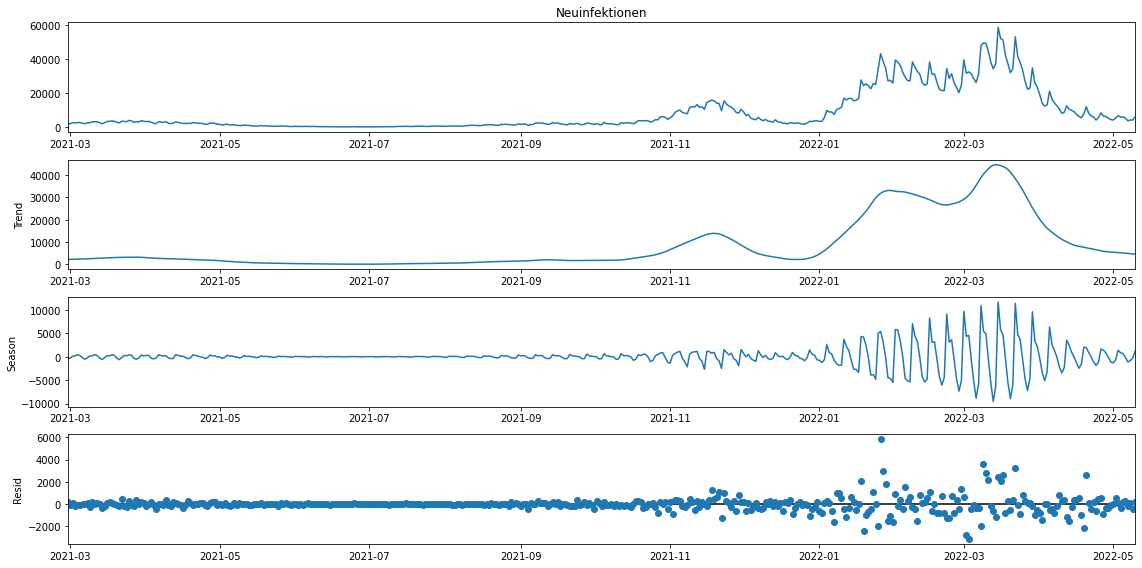

In [6]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [7]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

c:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,Neuinfektionen
2022-05-11,5 429
2022-05-12,5 742
2022-05-13,4 963
2022-05-14,3 473
2022-05-15,4 047
2022-05-16,3 995
2022-05-17,5 947


## Hospitalisierung
### Werte der letzten 7 Tage

In [8]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(7*10)["HospitalisierungDiff"],
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-05-04,69 (-9),83 (7),247 (-4),97 (-8),30 (1),142 (-1),53 (-5),23 (0),333 (-15),1 077 (-34)
2022-05-05,65 (-4),75 (-8),232 (-15),107 (10),24 (-6),129 (-13),47 (-6),23 (0),336 (3),1 038 (-39)
2022-05-06,61 (-4),71 (-4),230 (-2),107 (0),26 (2),118 (-11),45 (-2),17 (-6),308 (-28),983 (-55)
2022-05-07,61 (0),71 (0),216 (-14),107 (0),26 (0),118 (0),45 (0),17 (0),285 (-23),946 (-37)
2022-05-08,61 (0),67 (-4),209 (-7),103 (-4),26 (0),118 (0),45 (0),19 (2),293 (8),941 (-5)
2022-05-09,54 (-7),67 (0),214 (5),101 (-2),31 (5),105 (-13),44 (-1),15 (-4),294 (1),925 (-16)
2022-05-10,55 (1),62 (-5),191 (-23),83 (-18),30 (-1),108 (3),45 (1),15 (0),283 (-11),872 (-53)


### Diagramm

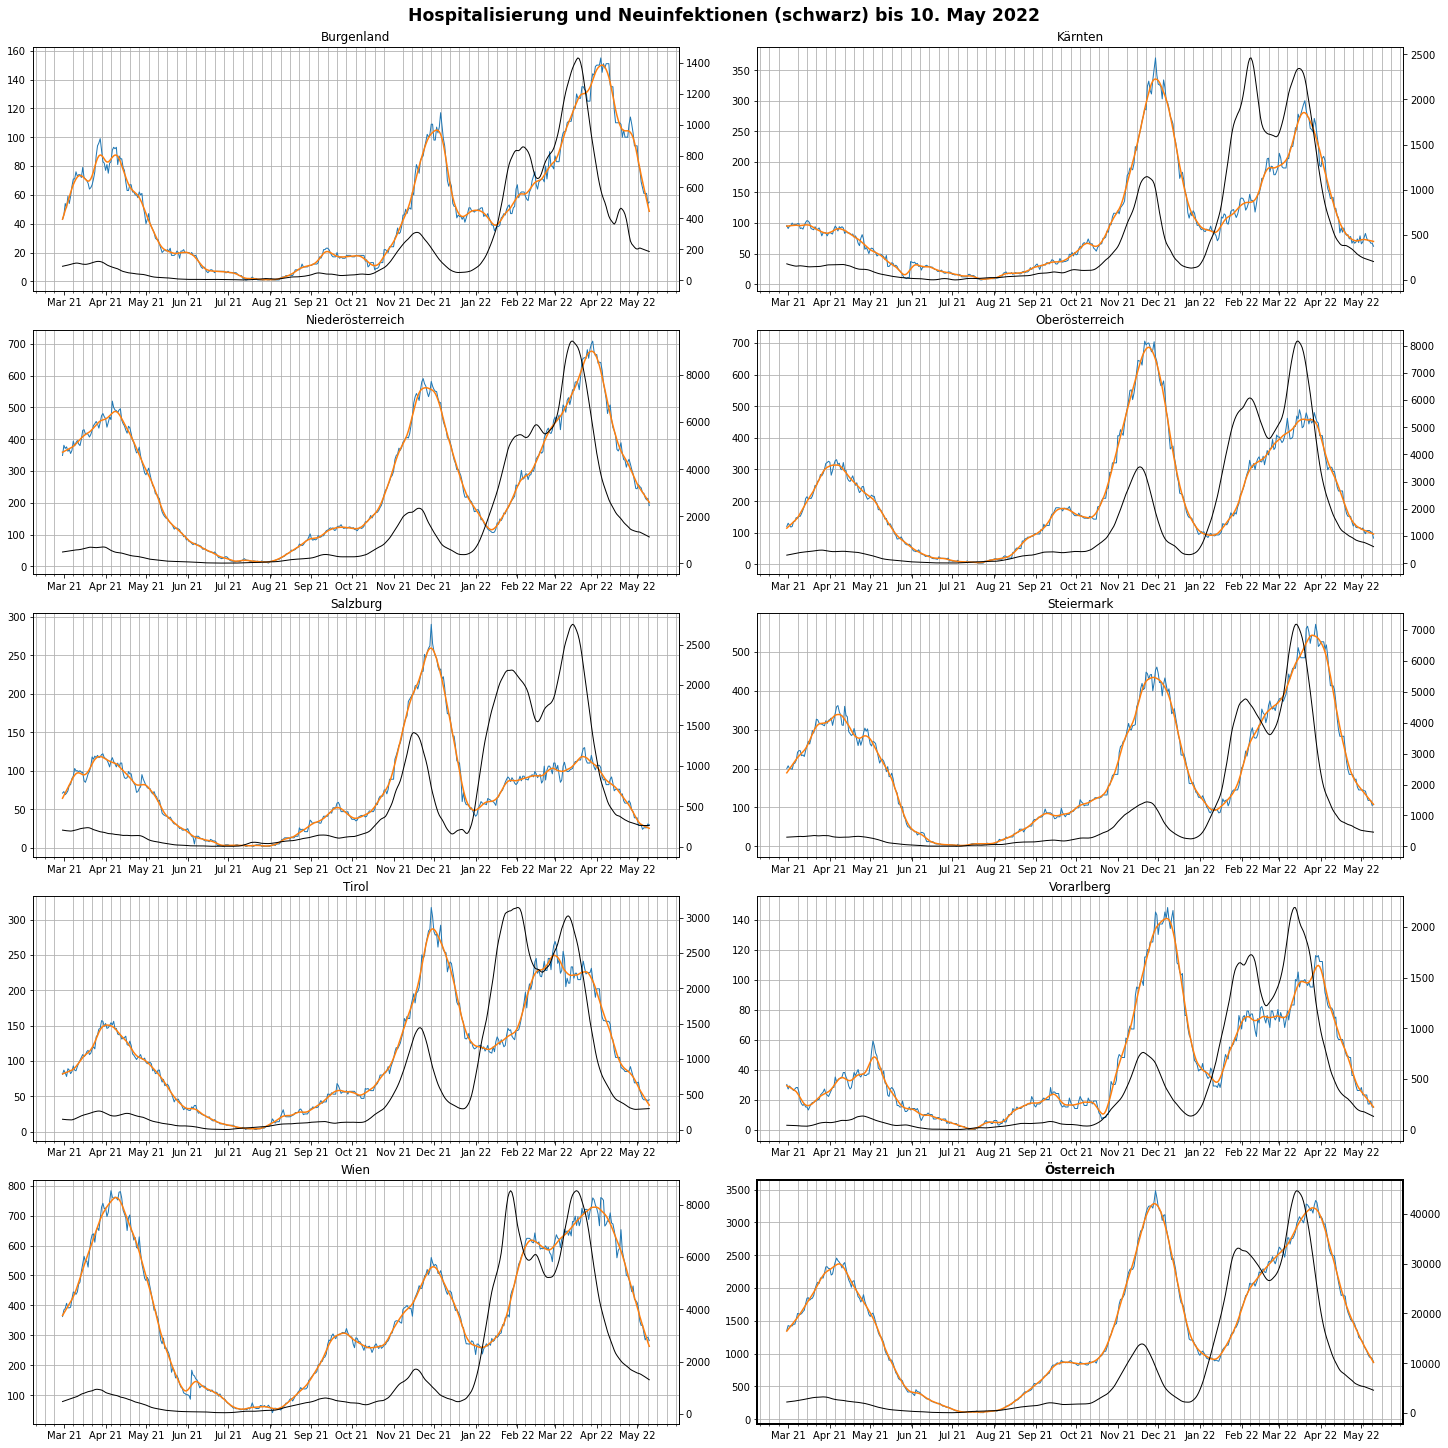

In [9]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

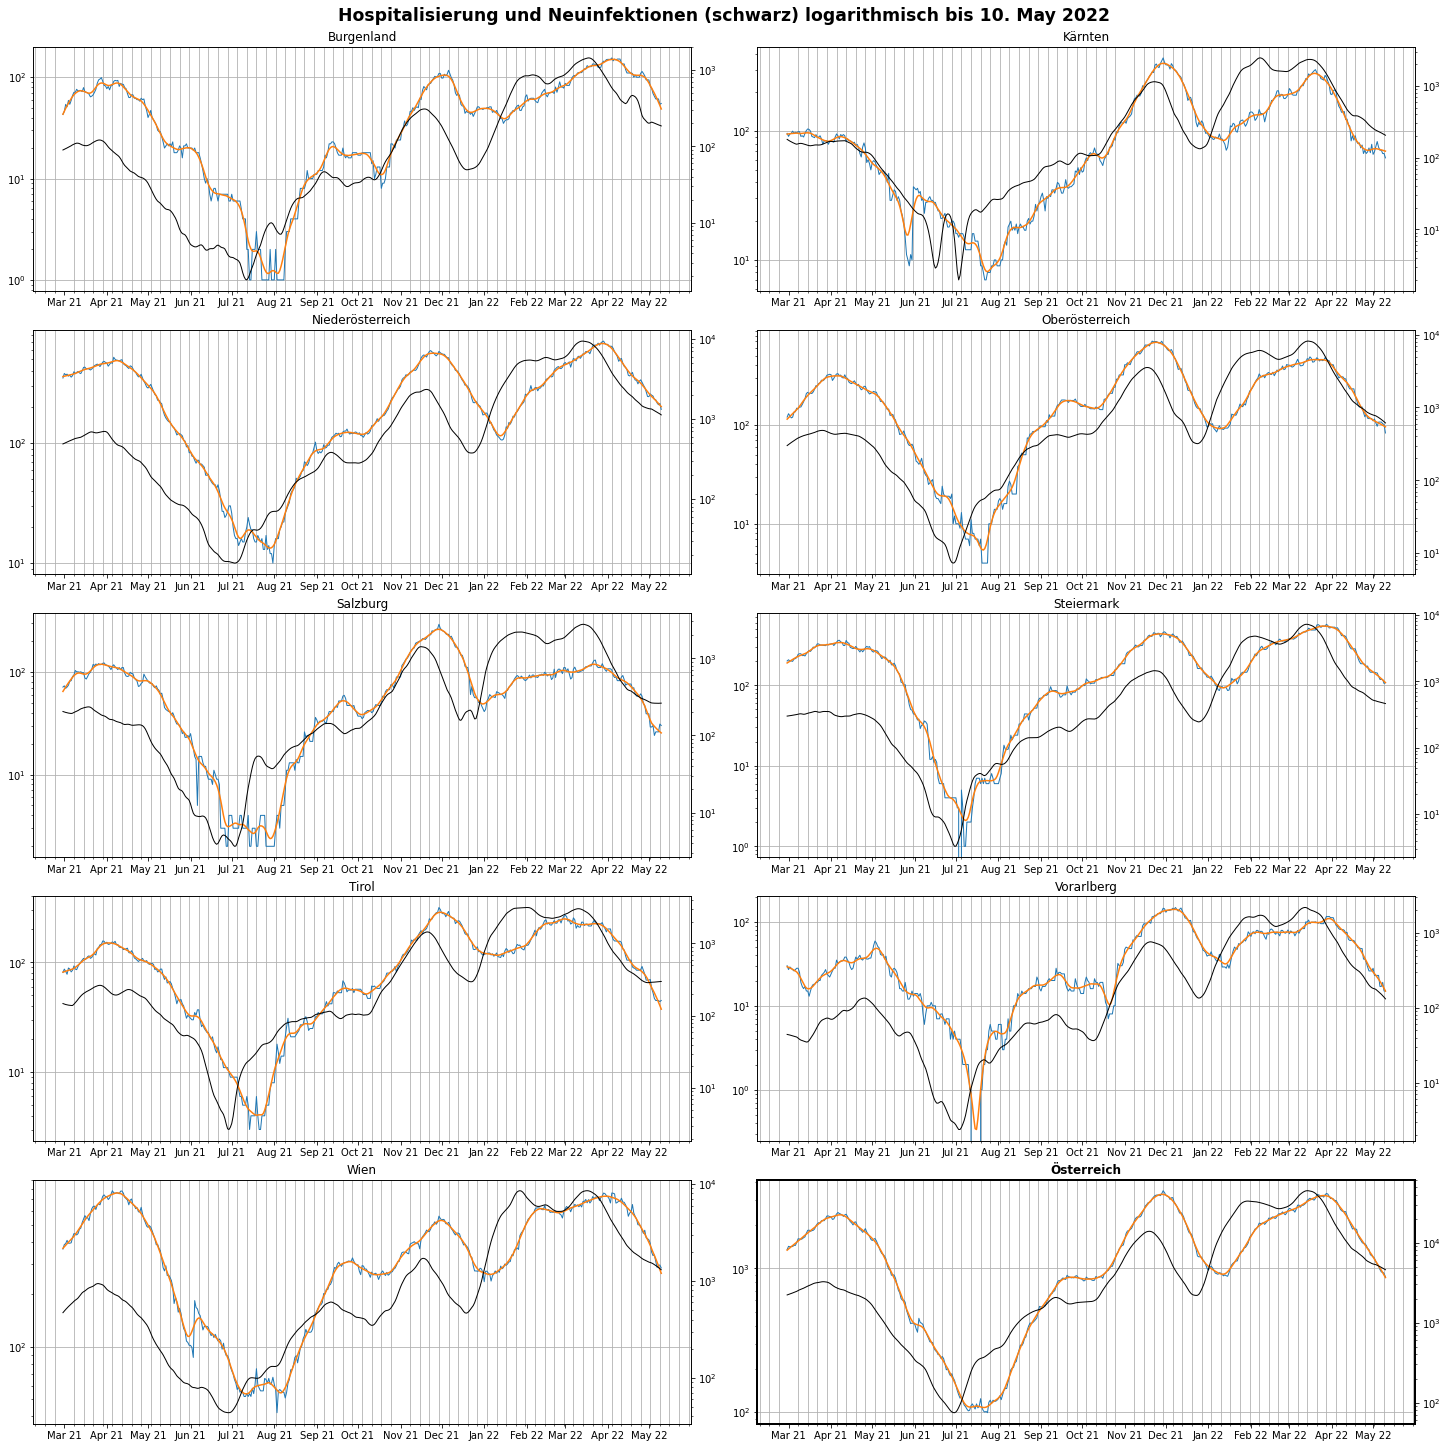

In [10]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [11]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCR": data.tail(7*10)["TestungenPCR"],
        "Diff": data.tail(8*10)["TestungenPCR"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCR:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-05-04,4 372 (629),1 326 (296),6 041 (-2 651),2 400 (-872),1 701 (-503),5 387 (-1 938),2 838 (35),745 (-259),109 130 (-30 902),133 940 (-36 165)
2022-05-05,2 748 (-1 624),969 (-357),166 477 (160 436),4 368 (1 968),1 519 (-182),6 475 (1 088),2 428 (-410),755 (10),88 937 (-20 193),274 676 (140 736)
2022-05-06,2 704 (-44),838 (-131),7 646 (-158 831),2 993 (-1 375),1 296 (-223),5 035 (-1 440),2 455 (27),525 (-230),65 782 (-23 155),89 274 (-185 402)
2022-05-07,2 570 (-134),675 (-163),6 832 (-814),2 374 (-619),1 040 (-256),4 688 (-347),2 158 (-297),546 (21),51 587 (-14 195),72 470 (-16 804)
2022-05-08,2 258 (-312),1 090 (415),4 385 (-2 447),2 699 (325),823 (-217),2 584 (-2 104),1 205 (-953),517 (-29),48 068 (-3 519),63 629 (-8 841)
2022-05-09,1 541 (-717),1 390 (300),7 108 (2 723),3 755 (1 056),2 093 (1 270),5 133 (2 549),3 383 (2 178),699 (182),135 685 (87 617),160 787 (97 158)
2022-05-10,4 298 (2 757),1 279 (-111),9 269 (2 161),2 336 (-1 419),1 413 (-680),6 386 (1 253),2 621 (-762),748 (49),135 428 (-257),163 778 (2 991)


### Diagramm

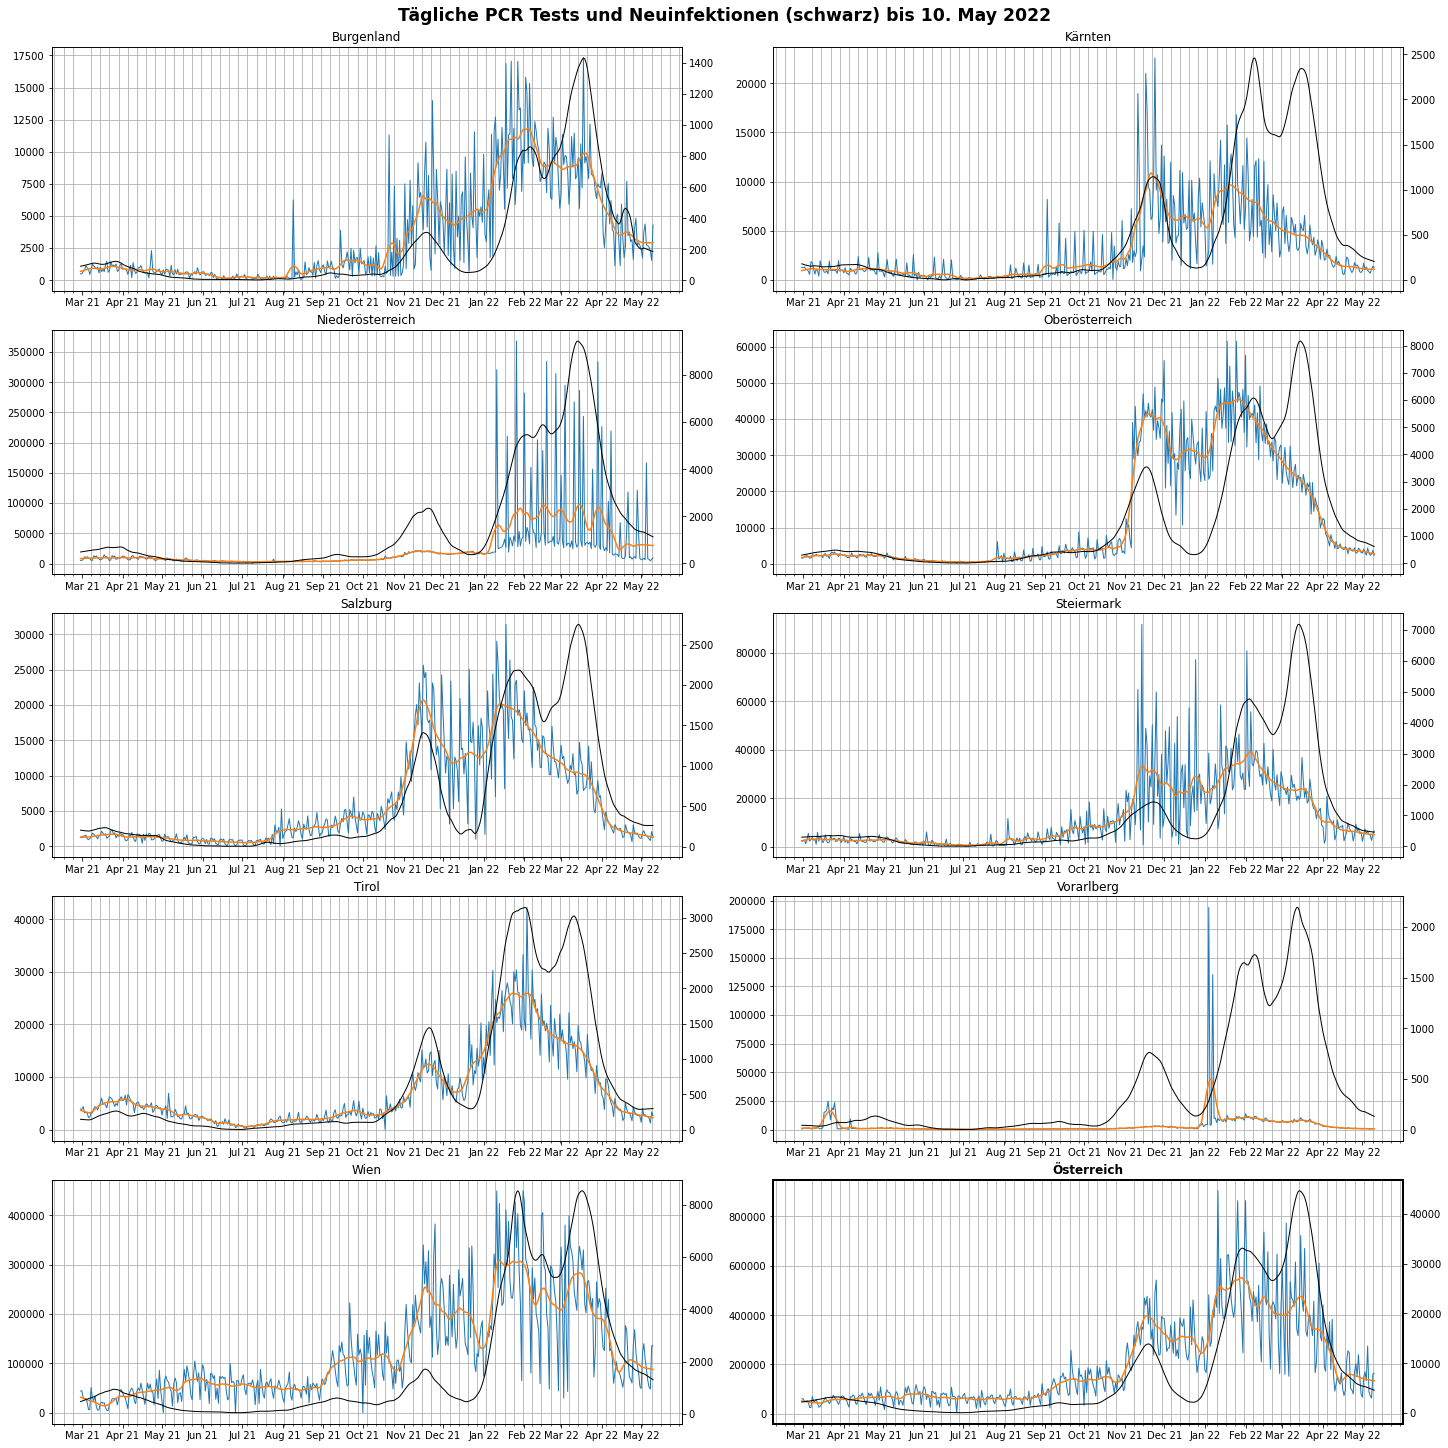

In [12]:
plot_param(["TestungenPCR", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)